In [1]:
import sys
sys.path.append("scripts/")
from GridMap import *
import math
from matplotlib.animation import PillowWriter    #アニメーション保存用

In [33]:
class Dstar():
    def __init__(self, grid_map_world):
        self.world = grid_map_world
        self.real_grid_map = grid_map_world.grid_map #実際のマップ
        self.metric_grid_map = np.full(self.real_grid_map.shape, -1)  #測定により得られたマップ
        self.cost_map = np.full(self.real_grid_map.shape, 1)    #その地点が持つコスト
        self.id_map = np.full(self.real_grid_map.shape, 0)
        self.parent_id_map = np.full(self.real_grid_map.shape, 0)
        
        self.h_map = np.full(self.real_grid_map.shape, 10000.0)
        self.k_map = np.full(self.real_grid_map.shape, 10000.0)
        
        self.robot_index = self.world.start_index
        self.flag_path_draw = 0  #経路描画のフラグ
        self.flag_map_update = False  #マップ更新のフラグ
        
        self.open_list = []
        self.closed_list = []
        
        index = 0
        for index_x, grids in enumerate(self.real_grid_map):
            for index_y, grid in enumerate(grids):
                self.id_map[index_x][index_y] = index;
                #self.h_map[index_x][index_y] = 10*math.sqrt((self.world.goal_index[0]-index_x)**2+(self.world.goal_index[1]-index_y)**2)
                #self.h_map[index_x][index_y] = abs(self.world.goal_index[0]-index_x) + abs(self.world.goal_index[1]-index_y)
                if(grid == '3'):
                    self.h_map[index_x][index_y] = 0
                    self.open_list.append([index, self.h_map[index_x][index_y], 0])
                index += 1
             
        while(1):
            val = np.argmin(self.open_list, axis=0) #評価マップの中から最も小さいもの抽出
            grid_id = self.open_list[val[1]][0]
            cost_h = self.open_list[val[1]][1]
            cost_k = self.open_list[val[1]][2]

            idx = np.where(self.id_map==grid_id)
            index = [idx[0][0], idx[1][0]]

            self.open_list.remove([grid_id, cost_h, cost_k])  #オープンリストから削除
            self.closed_list.append([grid_id, cost_h, cost_k])  #クローズドリストに追加

            if(self.world.grid_map[index[0]][index[1]] == '2'):
                break
            for i in range(-1, 2):
                    if(index[0]+i<0 or index[0]+i>self.cost_map.shape[0]-1): #地図の範囲外か（x軸方向）
                        continue;
                    for j in range(-1, 2):
                        if(index[1]+j<0 or index[1]+j>self.cost_map.shape[1]-1): #地図の範囲外か（y軸方向）
                            continue;
                        if(i==0 and j==0): #自分か
                            continue;
                        elif(self.metric_grid_map[index[0]+i][index[1]+j] == '0'): #障害物か
                            continue;
                        else:
                            new_cost_h = cost_h + math.sqrt(i**2 + j**2)
                            new_cost_k = new_cost_h
                            if(self.id_map[index[0]+i][index[1]+j] in [val[0] for val in self.open_list]): #オープンリストに含まれているか
                                if(self.h_map[index[0]+i][index[1]+j] > new_cost_h):
                                    self.open_list.remove([
                                        self.id_map[index[0]+i][index[1]+j], \
                                        self.h_map[index[0]+i][index[1]+j], \
                                        self.k_map[index[0]+i][index[1]+j]
                                    ])
                                    self.h_map[index[0]+i][index[1]+j] = new_cost_h
                                    self.k_map[index[0]+i][index[1]+j] = new_cost_h
                                    self.open_list.append([
                                        self.id_map[index[0]+i][index[1]+j], \
                                        self.h_map[index[0]+i][index[1]+j], \
                                        self.k_map[index[0]+i][index[1]+j]
                                    ])
                            elif(self.id_map[index[0]+i][index[1]+j] in [val[0] for val in self.closed_list]):
                                continue
                            else:
                                self.h_map[index[0]+i][index[1]+j] = new_cost_h
                                self.k_map[index[0]+i][index[1]+j] = new_cost_h
                                self.open_list.append([
                                    self.id_map[index[0]+i][index[1]+j], \
                                    self.h_map[index[0]+i][index[1]+j], \
                                    self.k_map[index[0]+i][index[1]+j]
                                ])
    
    def draw(self, ax, elems):
        r = patches.Rectangle(
            xy=((self.robot_index[0])*self.world.grid_step[0], (self.robot_index[1])*self.world.grid_step[1]),
            height=self.world.grid_step[0],
            width=self.world.grid_step[1],
            color="blue",
            fill=True
        )
        #self.robot_index[0] += 1
        #self.robot_index[1] += 1
        
        #障害物の確認
        elems.append(ax.add_patch(r))
        self.flag_map_update = False
        for i in range(-5, 10):
                if(self.robot_index[0]+i<0 or self.robot_index[0]+i>self.cost_map.shape[0]-1): #地図の範囲外か（x軸方向）
                    continue;
                for j in range(-5, 10):
                    if(self.robot_index[1]+j<0 or self.robot_index[1]+j>self.cost_map.shape[1]-1): #地図の範囲外か（y軸方向）
                        continue;
                    if(i==0 and j==0): #自分か
                        continue;
                    else:
                        if(self.metric_grid_map[self.robot_index[0]+i][self.robot_index[1]+j] == -1):
                            self.metric_grid_map[self.robot_index[0]+i][self.robot_index[1]+j] = self.real_grid_map[self.robot_index[0]+i][self.robot_index[1]+j]
                            if(self.real_grid_map[self.robot_index[0]+i][self.robot_index[1]+j] == '0'):
                                r = patches.Rectangle(
                                    xy=((self.robot_index[0]+i)*self.world.grid_step[0], (self.robot_index[1]+j)*self.world.grid_step[1]),
                                    height=self.world.grid_step[0],
                                    width=self.world.grid_step[1],
                                    color="black",
                                    fill=True
                                )
                                ax.add_patch(r)
                                self.flag_map_update = True
                            else:
                                pass
                                
        if not(self.flag_map_update):
            pass
        else:
            next_grid_cost = 10000
            next_grid_index = self.robot_index
            while(self.world.grid_map[next_grid_index[0]][next_grid_index[1]] !='3'):
                origin_grid_index = next_grid_index
                r = patches.Rectangle(
                    xy=(next_grid_index[0]*self.world.grid_step[0], next_grid_index[1]*self.world.grid_step[1]),
                    height=self.world.grid_step[0],
                    width=self.world.grid_step[1],
                    color="red",
                    fill=True
                )
                ax.add_patch(r)
                for i in range(-1, 2):
                    if(origin_grid_index[0]+i<0 or origin_grid_index[0]+i>self.cost_map.shape[0]-1): #地図の範囲外か（x軸方向）
                        continue;
                    for j in range(-1, 2):
                        if(origin_grid_index[1]+j<0 or origin_grid_index[1]+j>self.cost_map.shape[1]-1): #地図の範囲外か（y軸方向）
                            continue;
                        if(i==0 and j==0): #自分か
                            continue;
                        if(next_grid_cost > self.h_map[origin_grid_index[0]+i][origin_grid_index[1]+j]):
                            next_grid_cost = self.h_map[origin_grid_index[0]+i][origin_grid_index[1]+j]
                            next_grid_index = [origin_grid_index[0]+i, origin_grid_index[1]+j]
                                
        '''
        if not(self.id_map[self.world.goal_index[0]][self.world.goal_index[1]] in [val[0] for val in self.closed_list]): #ゴールにたどり着いていなければコストを計算
            val = np.argmin(self.open_list, axis=0) #評価マップの中から最も小さいもの抽出
            grid_id = self.open_list[val[1]][0]
            cost_f = self.open_list[val[1]][1]
            cost_g = self.open_list[val[1]][2]
            
            idx = np.where(self.id_map==grid_id)
            index = [idx[0][0], idx[1][0]]
            
            self.open_list.remove([grid_id, cost_f, cost_g])  #オープンリストから削除
            self.closed_list.append([grid_id, cost_f, cost_g])  #クローズドリストに追加
            
            if(self.world.grid_map[index[0]][index[1]]!='2' and self.world.grid_map[index[0]][index[1]]!='3'):
                c = "blue"
                fill=False
                
                r = patches.Rectangle(
                xy=((index[0])*self.world.grid_step[0], (index[1])*self.world.grid_step[1]),
                height=self.world.grid_step[0],
                width=self.world.grid_step[1],
                color=c,
                fill=fill
                )
                ax.add_patch(r)
            
            for i in range(-1, 2):
                if(index[0]+i<0 or index[0]+i>self.cost_map.shape[0]-1): #地図の範囲外か（x軸方向）
                    continue;
                for j in range(-1, 2):
                    if(index[1]+j<0 or index[1]+j>self.cost_map.shape[1]-1): #地図の範囲外か（y軸方向）
                        continue;
                    if(i==0 and j==0): #自分か
                        continue;
                    elif(self.grid_map[index[0]+i][index[1]+j] == '0'): #障害物か
                        continue;
                    else:
                        #評価を計算
                        evaluation_f = \
                            cost_g \
                            + self.cost_map[index[0]+i][index[1]+j] \
                            + 10*math.sqrt(i**2+j**2) \
                            + self.h_map[index[0]+i][index[1]+j]
                        
                        if(self.id_map[index[0]+i][index[1]+j] in [val[0] for val in self.open_list]): #オープンリストに含まれているか
                            its_index, its_cost_f, its_cost_g = self.open_list[[val[0] for val in self.open_list].index(self.id_map[index[0]+i][index[1]+j])]
                            if(its_cost_f > evaluation_f): #評価が更新されなければ繰り返しを戻す
                                self.open_list.remove([its_index, its_cost_f, its_cost_g])
                            else:
                                continue;
                        elif(self.id_map[index[0]+i][index[1]+j] in [val[0] for val in self.closed_list]): #クローズドリストに含まれているか 
                            its_index, its_cost_f, its_cost_g = self.closed_list[[val[0] for val in self.closed_list].index(self.id_map[index[0]+i][index[1]+j])]
                            if(its_cost_f > evaluation_f):
                                self.closed_list.remove([its_index, its_cost_f, its_cost_g])  
                            else:
                                continue;
                        self.parent_id_map[index[0]+i][index[1]+j] = self.id_map[index[0]][index[1]]
                        self.open_list.append([
                            self.id_map[index[0]+i][index[1]+j], \
                            evaluation_f, \
                            evaluation_f - self.h_map[index[0]+i][index[1]+j]
                        ])
        else:
            if(self.flag_path_draw == 0):
                parent_id = self.parent_id_map[self.world.goal_index[0]][self.world.goal_index[1]]
                while(parent_id != self.id_map[self.world.start_index[0]][self.world.start_index[1]]):
                    parent = np.where(self.id_map==parent_id)
                    parent_id = self.parent_id_map[int(parent[0])][int(parent[1])]
                    r = patches.Rectangle(
                        xy=((parent[0])*self.world.grid_step[0], (parent[1])*self.world.grid_step[1]),
                        height=self.world.grid_step[0],
                        width=self.world.grid_step[1],
                        color="red",
                        fill=True
                    )
                    ax.add_patch(r)
                self.flag_path_draw = 1
                print(self.flag_path_draw)
        '''

<IPython.core.display.Javascript object>


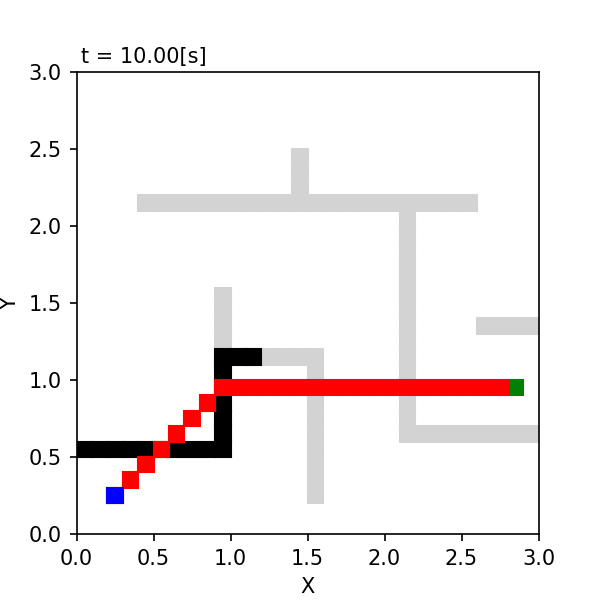

In [34]:
if __name__ == "__main__":
    time_span = 10
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "csvmap/map2.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False, isDynamic=True)
    world.append(Dstar(world))
    
    world.draw()
    #world.ani.save('astar_map2.gif', writer='pillow', fps=100)    #アニメーション保存